In [2]:
import numpy as np
import pandas as pd
#from pandas import DataFrame

import matplotlib

import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'

2020-12-04 10:25:00,473 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/Documents/GitHub/climada_python/climada/conf/defaults.conf


## Damage cost for each scenario, year and labor type

In [3]:
pickle_in = \
open('/Users/zeliestalhanske/Documents/GitHub/master_thesis/output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
loss_productivity = pickle.load(pickle_in)  
pickle_in = \
open('/Users/zeliestalhanske/Documents/GitHub/master_thesis/output/impact_ch/matrix_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
matrices_productivity = pickle.load(pickle_in) 
scenarios = ['RCP26', 'RCP45', 'RCP85']
years = ['2020','2035','2050']
n_mc=1000
impact_productivity = ImpactsHeatProductivity(scenarios, years, n_mc)
impact_productivity.agg_impacts_mc = loss_productivity
impact_productivity.median_impact_matrices = matrices_productivity 


In [3]:
exposures = {}
exposures['outside high physical activity'] = Exposures()
exposures['outside high physical activity'].read_hdf5('../../input_data/exposures/exposures_productivity_ch_OH.h5')
exposures['outside high physical activity']['value'] = exposures['outside high physical activity']['value']*8*52*5

exposures['inside low physical activity'] = Exposures()
exposures['inside low physical activity'].read_hdf5('../../input_data/exposures/exposures_productivity_ch_IL.h5')
exposures['inside low physical activity']['value'] = exposures['inside low physical activity']['value']*8*52*5

exposures['inside moderate physical activity'] = Exposures()
exposures['inside moderate physical activity'].read_hdf5('../../input_data/exposures/exposures_productivity_ch_IM.h5')
exposures['inside moderate physical activity']['value'] = exposures['inside moderate physical activity']['value']*8*52*5

exposures['outside moderate physical activity'] = Exposures()
exposures['outside moderate physical activity'].read_hdf5('../../input_data/exposures/exposures_productivity_ch_OM.h5')
exposures['outside moderate physical activity']['value'] = exposures['outside moderate physical activity']['value']*8*52*5


2020-11-24 15:27:31,337 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_productivity_ch_OH.h5
2020-11-24 15:27:32,474 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_productivity_ch_IL.h5
2020-11-24 15:27:33,745 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_productivity_ch_IM.h5
2020-11-24 15:27:35,086 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_productivity_ch_OM.h5


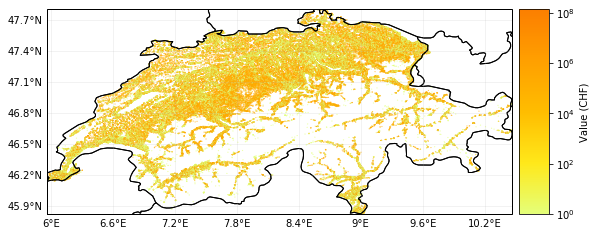

In [3]:
exposures['outside high physical activity'].value_unit = 'CHF'
exposures['outside high physical activity'].plot_hexbin(pop_name=False, norm=matplotlib.colors.LogNorm())

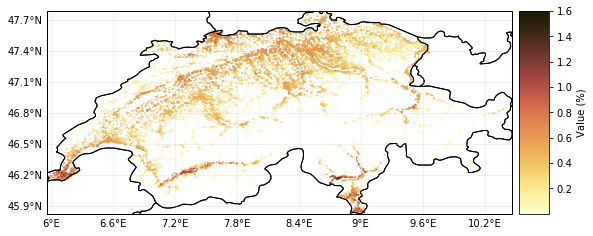

In [9]:
impact_high = impact_productivity.matrix_as_impact(impact_productivity.median_impact_matrices['RCP85']['2050']['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=True, unit='%')
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

impact_high.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, vmax=1.6)

In [12]:
categories = {'inside low physical activity': 'IL', 'inside moderate physical activity': 'IM',
                           'outside moderate physical activity': 'OM', 'outside high physical activity': 'OH'}
relative_matrices = impact_productivity.get_relative_change_matrices('2020', categories)

In [14]:
relative_matrice_high = impact_productivity.matrix_as_impact(relative_matrices['RCP85']['2050']['outside high physical activity'],
                                                            exposures['outside high physical activity'], percentage=False, unit='%')


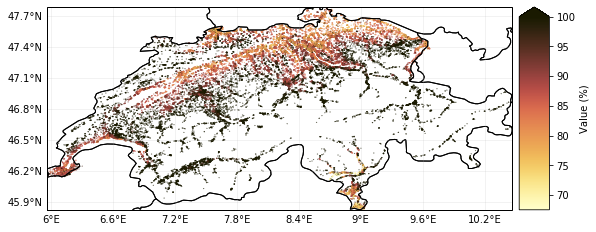

In [15]:
relative_matrice_high.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, vmax=100, extend='max')

In [13]:
pickle_in = \
open('/Users/zeliestalhanske/Documents/GitHub/master_thesis/output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH_2065.pickle','rb')
loss_productivity_2065 = pickle.load(pickle_in) 
scenarios = ['RCP26', 'RCP45', 'RCP85']
years = ['2065']
n_mc=1000
impact_productivity_2065 = ImpactsHeatProductivity(scenarios, years, n_mc)
impact_productivity_2065.agg_impacts_mc = loss_productivity_2065

impact_productivity.append_years(impact_productivity_2065)

In [4]:
pickle_in = \
open('/Users/zeliestalhanske/Documents/GitHub/master_thesis/output/impact_ch/impacts_all_branches_100mc_all_uncertainties_CH_2080.pickle','rb')
loss_productivity_2080 = pickle.load(pickle_in) 
scenarios = ['RCP26', 'RCP45', 'RCP85']
years = ['2080']
n_mc=1000
impact_productivity_2080 = ImpactsHeatProductivity(scenarios, years, n_mc)
impact_productivity_2080.agg_impacts_mc = loss_productivity_2080
impact_productivity.append_years(impact_productivity_2080)

In [11]:
(impact_productivity.agg_impacts_mc['RCP85']['2080'].median(axis=0).sum()-impact_productivity.agg_impacts_mc['RCP26']['2080'].median(axis=0).sum())/impact_productivity.agg_impacts_mc['RCP85']['2080'].median(axis=0).sum()


0.5543568151788486

In [15]:
impact_productivity.costs_in_millions()


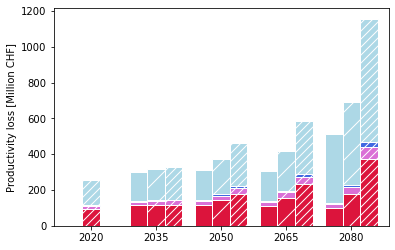

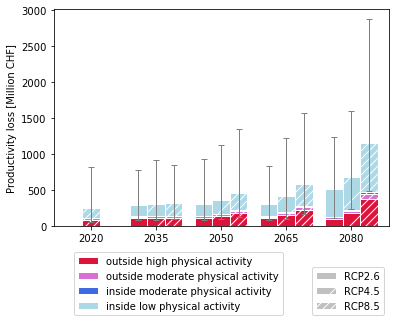

In [6]:
plot_impacts_heat(impact_productivity.agg_impacts_mc, 'Productivity loss [Million CHF]', impact_type='productivity', color=['crimson','orchid','royalblue','lightblue'], save=True)


In [25]:
print(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.05))/1000000)
print(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].median()))


132.04153141816835
463555654.0806911


In [16]:
print((np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.95))/(np.sum(impact_productivity.agg_impacts_mc['RCP85']['2050'].quantile(0.5)))))


2.907300794758943


In [187]:
il_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['inside low physical activity'].mean()/(exposures_low.value.sum()/1000000)
oh_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['outside high physical activity'].mean()/(exposures_high.value.sum()/1000000)
om_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['outside moderate physical activity'].mean()/(exposures_om.value.sum()/1000000)
im_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['inside moderate physical activity'].mean()/(exposures_im.value.sum()/1000000)
total_percent = 100*impact_productivity.agg_impacts_mc['RCP85']['2050']['total'].mean()/((exposures_low.value.sum()+exposures_high.value.sum()+exposures_om.value.sum()+exposures_im.value.sum())/1000000)



In [198]:
impact_productivity.agg_impacts_mc['RCP26']['2080']['outside high physical activity'].mean()/impact_productivity.agg_impacts_mc['RCP26']['2080']['total'].mean()



0.25104576829915987

In [19]:
def median_death(impacts, scenario, year, category='all'):
    if category=='all':
        median_death = [np.median(impacts.agg_impacts_mc[scenario][year][cat]) for cat in impacts.agg_impacts_mc[scenario][year]]
    else:    
        median_death = np.median(impacts.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(impacts, scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(impacts, scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts.agg_impacts_mc[scenario][year][category])
    return median_death

In [21]:
(np.sum(median_death(impact_productivity, 'RCP26', '2050')) - np.sum(median_death(impact_productivity, 'RCP26', '2020')))/np.sum(median_death(impact_productivity, 'RCP26', '2020'))

0.18981975948552188

## table with cantonal values

In [ ]:


categories_short = {'inside low physical activity': 'IL', 'inside moderate physical activity': 'IM',
                           'outside moderate physical activity': 'OM', 'outside high physical activity': 'OH'}
cantonal_impacts_df = impact_productivity.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=['2020', '2050', '2080'], categories=['inside low physical activity', 'outside high physical activity'], categories_short=categories_short)


In [8]:
cantonal_impacts_df

RCP2.6                                     \
                              2020                   2050               
                                IL         OH          IL          OH   
canton                                                                  
Aargau                    8.722731   8.199777    9.972643    9.997308   
Appenzell Ausserrhoden    0.419657   0.143456    0.469054    0.179324   
Appenzell Innerrhoden     0.109453   0.056251    0.122815    0.070189   
Basel-Landschaft          4.292960   4.083330    4.951807    5.070551   
Basel-Stadt               6.946585   3.484772    8.099090    4.334908   
Bern                     15.939638   8.764675   18.095906   11.078731   
Fribourg                  3.510642   2.721180    4.001811    3.468965   
Genève                   14.919491   9.665122   18.303755   12.364633   
Glarus                    0.332139   0.282708    0.375733    0.360327   
Graubünden                2.107674   1.905632    2.500543    2.489939   
Jura                      0.854880   0.596882    0.990537    0.760983   
Luzern                    5.965120   4.347231    6.726134    5.334937   
Neuchâtel                 2.261880   1.107838    2.648847    1.418333   
Nidwalden                 0.515932   0.328912    0.589727    0.414092   
Obwalden                  0.383422   0.326687    0.442084    0.424230   
Schaffhausen              1.082905   0.904695    1.220440    1.097985   
Schwyz                    1.847345   1.300584    2.078886    1.614501   
Solothurn                 3.391812   2.953081    3.895542    3.638530   
St. Gallen                5.705976   3.885416    6.378882    4.725303   
Thurgau                   2.927786   2.468631    3.233428    2.966284   
Ticino                    7.753899   7.640942    9.080480    9.415843   
Uri                       0.282057   0.245681    0.329695    0.336245   
Valais                    4.137543   3.886959    5.137533    5.703041   
Vaud                     14.162827   7.231270   16.395479    9.442686   
Zug                       2.996735   1.525864    3.365589    1.864475   
Zürich                   35.533406  16.101155   40.299662   19.606118   
Total                   147.104495  94.158731  169.706103  118.178461   

                            RCP8.5                                     
                              2020                   2050              
                                IL         OH          IL          OH  
canton                                                                 
Aargau                    8.176693   8.102535   14.026087   14.815870  
Appenzell Ausserrhoden    0.400789   0.143020    0.662774    0.303952  
Appenzell Innerrhoden     0.105213   0.055494    0.173601    0.119749  
Basel-Landschaft          4.057040   4.077344    6.896223    7.461703  
Basel-Stadt               6.653131   3.538646   11.199727    6.299300  
Bern                     15.056204   8.665193   25.741996   16.934818  
Fribourg                  3.318740   2.728427    5.709001    5.372775  
Genève                   14.561760   9.758116   25.468772   18.175454  
Glarus                    0.312595   0.276109    0.544197    0.584499  
Graubünden                1.974351   1.837291    3.650552    4.076245  
Jura                      0.808663   0.596352    1.389345    1.153390  
Luzern                    5.584425   4.240810    9.661135    8.224756  
Neuchâtel                 2.145131   1.117898    3.696214    2.170554  
Nidwalden                 0.480609   0.322376    0.836099    0.647656  
Obwalden                  0.361922   0.318713    0.626809    0.672273  
Schaffhausen              1.018675   0.896060    1.728269    1.642386  
Schwyz                    1.740472   1.273824    2.959899    2.555511  
Solothurn                 3.181019   2.947776    5.469766    5.411196  
St. Gallen                5.400406   3.836803    9.096810    7.358444  
Thurgau                   2.769327   2.472767    4.637330    4.497364  
Ticino                    7.262483  

In [9]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df.astype(int).to_latex(multicolumn=True))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{RCP2.6} & \multicolumn{4}{l}{RCP8.5} \\
{} & \multicolumn{2}{l}{2020} & \multicolumn{2}{l}{2050} & \multicolumn{2}{l}{2020} & \multicolumn{2}{l}{2050} \\
{} &     IL &  OH &   IL &   OH &     IL &  OH &   IL &   OH \\
canton                 &        &     &      &      &        &     &      &      \\
\midrule
Aargau                 &      8 &   8 &    9 &    9 &      8 &   8 &   14 &   14 \\
Appenzell Ausserrhoden &      0 &   0 &    0 &    0 &      0 &   0 &    0 &    0 \\
Appenzell Innerrhoden  &      0 &   0 &    0 &    0 &      0 &   0 &    0 &    0 \\
Basel-Landschaft       &      4 &   4 &    4 &    5 &      4 &   4 &    6 &    7 \\
Basel-Stadt            &      6 &   3 &    8 &    4 &      6 &   3 &   11 &    6 \\
Bern                   &     15 &   8 &   18 &   11 &     15 &   8 &   25 &   16 \\
Fribourg               &      3 &   2 &    4 &    3 &      3 &   2 &    5 &    5 \\
Genève                 &     14 &   9 &  